<a href="https://colab.research.google.com/github/RobinCross/RobinCross/blob/main/Denver_Crime_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install category_encoders==2.*

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.9/81.9 kB 843.0 kB/s eta 0:00:00


In [3]:
from category_encoders import OrdinalEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.metrics import ConfusionMatrixDisplay, classification_report
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
import numpy as np
import pandas as pd

In [ ]:
# def wrangle(fm_path, tv_path=None):
#   if tv_path:
#     df = pd.merge(pd.read_csv(fm_path,
#                               na_values=[0, -2.000000e-08],
#                               parse_dates=['date_recorded']),
#                   pd.read_csv(tv_path)).set_index('id')


#   else:

#     df = pd.read_csv(fm_path,
#                      na_values=[0, -2.000000e-08],
#                      parse_dates=['date_recorded'],
#                      index_col='id')


#   # Drop constant columns
#   df.drop(columns=['recorded_by'], inplace=True)

#   # Create age feature
#   df['pump_age'] = df['date_recorded'].dt.year - df['construction_year']
#   df.drop(columns='date_recorded', inplace=True)

#   # Drop HCCCs
#   cutoff = 100
#   drop_cols = [col for col in df.select_dtypes('object').columns
#               if df[col].nunique() > cutoff]
#   df.drop(columns=drop_cols, inplace=True)

#   # Drop duplicate columns # check for atleast a 100 values
#   dupe_cols = [col for col in df.head(100).T.duplicated().index
#                if df.head(100).T.duplicated()[col]]
#   df.drop(columns=dupe_cols, inplace=True)

#   return df

# df = wrangle(fm_path='train_features.csv',
#              tv_path='train_labels.csv')

# #X_test = wrangle(fm_path='test_features.csv')

In [6]:
df = pd.read_csv('crime.csv', encoding='latin-1')

In [7]:
df.head()

incident_id        offense_id  offense_code  offense_code_extension  \
0    202268791   202268791299900          2999                       0   
1   2021387586  2021387586299900          2999                       0   
2   2020641486  2020641486299900          2999                       0   
3   2020293614  2020293614299900          2999                       0   
4   2020600882  2020600882299900          2999                       0   

           offense_type_id offense_category_id  first_occurrence_date  \
0  criminal-mischief-other     public-disorder   2/10/2022 2:50:00 AM   
1  criminal-mischief-other     public-disorder    7/7/2021 9:02:00 PM   
2  criminal-mischief-other     public-disorder  10/29/2020 1:30:00 AM   
3  criminal-mischief-other     public-disorder    5/8/2020 5:00:00 AM   
4  criminal-mischief-other     public-disorder   10/8/2020 2:26:00 AM   

  last_occurrence_date          reported_date     incident_address      geo_x  \
0                  NaN   2/10/2022 3:16:00 AM   1107 N SANTA FE DR  3140929.0   
1                  NaN   7/8/2021 12:55:00 AM          815 16TH ST  3142470.0   
2                  NaN  10/29/2020 4:31:00 AM  4745 N FEDERAL BLVD  3133352.0   
3  5/8/2020 6:30:00 PM  5/13/2020 10:00:00 AM   12295 E ALBROOK DR  3184065.0   
4                  NaN   10/8/2020 3:43:00 AM      2100 W 30TH AVE  3137149.0   

       geo_y     geo_lon    geo_lat district_id  precinct_id neighborhood_id  \
0  1692612.0 -104.998910  39.733957           1          123    lincoln-park   
1  1697098.0 -104.993342  39.746248           6          611             cbd   
2  1710396.0 -105.025520  39.782888           1          111        berkeley   
3  1710782.0 -104.845074  39.783082           5          521       montbello   
4  1701888.0 -105.012173  39.759477           1          113        highland   

   is_crime  is_traffic  victim_count  
0         1           0             1  
1         1           0             1  
2         1           0             1  
3         1           0             1  
4         1           0             1

In [10]:
df.columns

Index(['incident_id', 'offense_id', 'offense_code', 'offense_code_extension',
       'offense_type_id', 'offense_category_id', 'first_occurrence_date',
       'last_occurrence_date', 'reported_date', 'incident_address', 'geo_x',
       'geo_y', 'geo_lon', 'geo_lat', 'district_id', 'precinct_id',
       'neighborhood_id', 'is_crime', 'is_traffic', 'victim_count'],
      dtype='object')

In [11]:
df = df.drop(columns = ['offense_id','offense_code','offense_code_extension','first_occurrence_date','last_occurrence_date','geo_x',
       'geo_y'])


In [12]:
df.head()

incident_id          offense_type_id offense_category_id  \
0    202268791  criminal-mischief-other     public-disorder   
1   2021387586  criminal-mischief-other     public-disorder   
2   2020641486  criminal-mischief-other     public-disorder   
3   2020293614  criminal-mischief-other     public-disorder   
4   2020600882  criminal-mischief-other     public-disorder   

           reported_date     incident_address     geo_lon    geo_lat  \
0   2/10/2022 3:16:00 AM   1107 N SANTA FE DR -104.998910  39.733957   
1   7/8/2021 12:55:00 AM          815 16TH ST -104.993342  39.746248   
2  10/29/2020 4:31:00 AM  4745 N FEDERAL BLVD -105.025520  39.782888   
3  5/13/2020 10:00:00 AM   12295 E ALBROOK DR -104.845074  39.783082   
4   10/8/2020 3:43:00 AM      2100 W 30TH AVE -105.012173  39.759477   

  district_id  precinct_id neighborhood_id  is_crime  is_traffic  victim_count  
0           1          123    lincoln-park         1           0             1  
1           6          611             cbd         1           0             1  
2           1          111        berkeley         1           0             1  
3           5          521       montbello         1           0             1  
4           1          113        highland         1           0             1

In [17]:
df.dtypes

incident_id              int64
offense_type_id         object
offense_category_id     object
reported_date           object
incident_address        object
geo_lon                float64
geo_lat                float64
district_id             object
precinct_id              int64
neighborhood_id         object
is_crime                 int64
is_traffic               int64
victim_count             int64
dtype: object

Reduce dataframe size to allow for easier modeling

In [34]:
keep_count = df['offense_category_id'].value_counts() * 0.01

sampled_rows = []

for crime_type, count in keep_count.items():

    crime_type_rows = df[df['offense_category_id'] == crime_type]

    sampled_crime_type_rows = crime_type_rows.sample(n=int(count), random_state=42)

    sampled_rows.append(sampled_crime_type_rows)

reduced_df = pd.concat(sampled_rows, ignore_index=True)

print(reduced_df['offense_category_id'].value_counts())

offense_category_id
theft-from-motor-vehicle        616
auto-theft                      557
public-disorder                 541
larceny                         521
all-other-crimes                418
burglary                        258
other-crimes-against-persons    189
drug-alcohol                    179
aggravated-assault              164
robbery                          63
white-collar-crime               60
sexual-assault                   37
arson                             7
murder                            3
Name: count, dtype: int64


In [26]:
import folium
import pandas as pd

# Assuming your DataFrame is named 'df'

# Create a base map centered on Denver
denver_map = folium.Map(location=[39.7392, -104.9903], zoom_start=11)

# Define a color map for different crime types
color_map = {
    'theft-from-motor-vehicle': 'red',
    'auto-theft': 'blue',
    'public-disorder': 'green',
    'larceny': 'yellow',
    'burglary': 'white'


    # Add more crime types and their corresponding colors
}

# Iterate over each row in the DataFrame
for index, row in reduced_df.iterrows():
    crime_type = row['offense_category_id']  # Adjust the column name based on your DataFrame
    latitude = row['geo_lat']
    longitude = row['geo_lon']

    # Skip rows with missing latitude or longitude
    if pd.isna(latitude) or pd.isna(longitude):
        continue

    # Get the color for the crime type, default to black if not specified
    color = color_map.get(crime_type, 'black')

    # Create a circle marker for each crime incident
    folium.CircleMarker(
        location=[latitude, longitude],
        radius=1,
        color=color,
        fill=True,
        fill_color=color,
        fill_opacity=0.7,
        popup=f"Crime Type: {crime_type}"
    ).add_to(denver_map)

# Display the map
denver_map

In [36]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Assuming your DataFrame is named 'df'

# Select the relevant features for prediction
features = ['offense_type_id', 'offense_category_id', 'district_id', 'precinct_id', 'neighborhood_id', 'is_crime', 'is_traffic']

# Create the feature matrix X and target vector y
X = pd.get_dummies(reduced_df[features], drop_first=True)
y = reduced_df['victim_count']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create a random forest regression model
model = RandomForestRegressor(n_estimators=100, random_state=42)

# Train the model
model.fit(X_train, y_train)

# Make predictions on the testing set
y_pred = model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"R-squared (R2) Score: {r2:.2f}")

Mean Squared Error (MSE): 0.07
Mean Absolute Error (MAE): 0.03
R-squared (R2) Score: -1.29


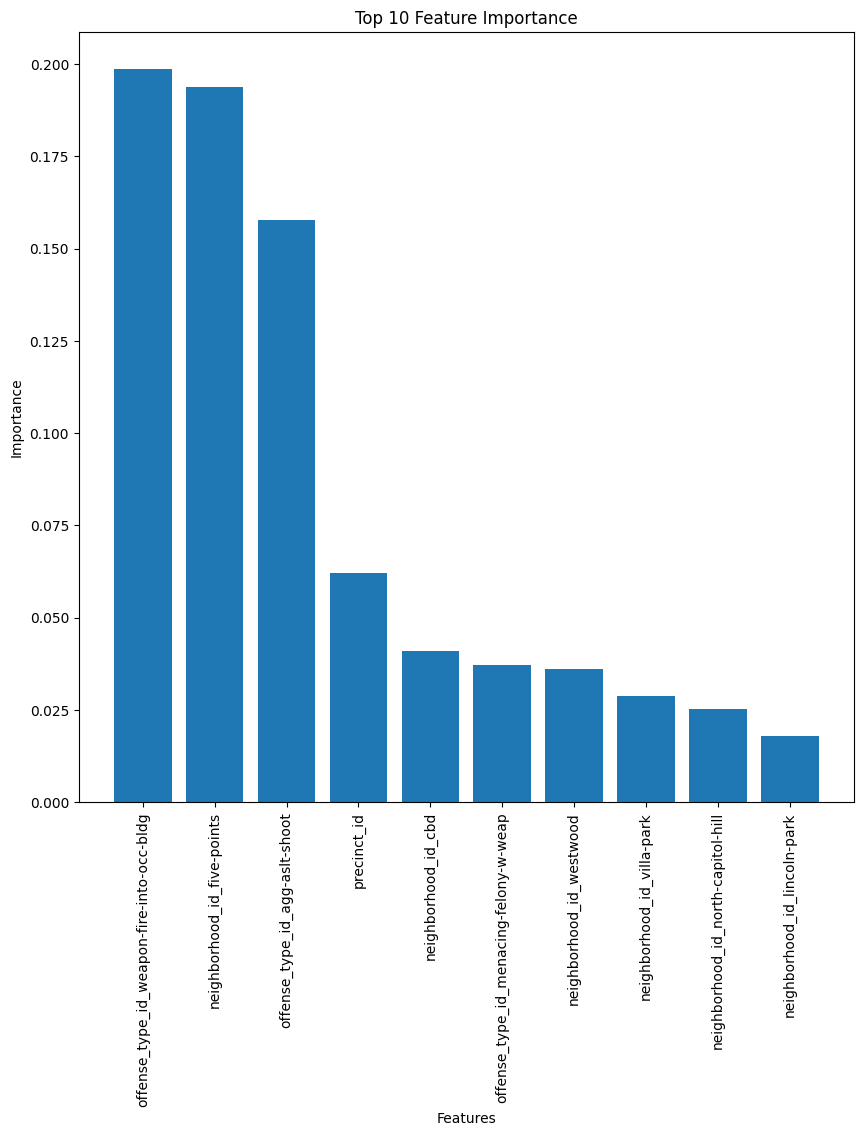

In [33]:
import pandas as pd
import matplotlib.pyplot as plt

# Get the feature importances and create a DataFrame
feature_importance = pd.DataFrame({'Feature': X.columns, 'Importance': model.feature_importances_})

# Sort the DataFrame by importance in descending order
feature_importance = feature_importance.sort_values('Importance', ascending=False)

# Select the top 10 features
top_features = feature_importance.head(10)

# Create the plot
plt.figure(figsize=(10, 10))
plt.bar(top_features['Feature'], top_features['Importance'])
plt.xlabel('Features')
plt.ylabel('Importance')
plt.title('Top 10 Feature Importance')
plt.xticks(rotation=45)
plt.show()

In [40]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# Assuming your DataFrame is named 'df'

# Select the relevant features and target variable
features = ['neighborhood_id', 'is_crime', 'is_traffic']
target = 'offense_category_id'

# Create the feature matrix X and target vector y
X = pd.get_dummies(reduced_df[features], drop_first=True)
y = reduced_df[target]

# Encode the target variable
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [41]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Create a random forest classifier
model = RandomForestClassifier(n_estimators=100, random_state=42)

# Train the model
model.fit(X_train, y_train)

# Make predictions on the testing set
y_pred = model.predict(X_test)

In [42]:
# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")

Accuracy: 0.18
Precision: 0.15
Recall: 0.18
F1 Score: 0.16


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [45]:
reduced_df['neighborhood_id'].head(100)

0      athmar-park
1          hampden
2        montbello
3      lowry-field
4              dia
          ...     
95       sunnyside
96             dia
97     west-colfax
98       montbello
99    central-park
Name: neighborhood_id, Length: 100, dtype: object

In [47]:
# Get the top 10 neighborhoods by count
top_neighborhoods = df['neighborhood_id'].value_counts().head(10).index

# Create a sample input for future prediction
future_input = pd.DataFrame({
    'neighborhood_id': top_neighborhoods,
    'is_crime': [1] * 10,
    'is_traffic': [0] * 10
})

# Get the feature names used during model training
train_features = X_train.columns

# Preprocess the future input
future_input = pd.get_dummies(future_input, drop_first=True)

# Align the future input with the training features
missing_features = set(train_features) - set(future_input.columns)
for feature in missing_features:
    future_input[feature] = 0

# Reorder the columns to match the training features
future_input = future_input[train_features]

# Make predictions on the future input
future_pred = model.predict(future_input)

# Decode the predicted labels
future_pred_labels = label_encoder.inverse_transform(future_pred)

# Print the predicted crime types for each neighborhood
print("Predicted Crime Types for Top 10 Neighborhoods:")
for neighborhood, crime_type in zip(top_neighborhoods, future_pred_labels):
    print(f"Neighborhood: {neighborhood}, Predicted Crime Type: {crime_type}")

Predicted Crime Types for Top 10 Neighborhoods:
Neighborhood: five-points, Predicted Crime Type: theft-from-motor-vehicle
Neighborhood: central-park, Predicted Crime Type: larceny
Neighborhood: dia, Predicted Crime Type: auto-theft
Neighborhood: capitol-hill, Predicted Crime Type: all-other-crimes
Neighborhood: cbd, Predicted Crime Type: larceny
Neighborhood: union-station, Predicted Crime Type: larceny
Neighborhood: montbello, Predicted Crime Type: auto-theft
Neighborhood: gateway-green-valley-ranch, Predicted Crime Type: public-disorder
Neighborhood: civic-center, Predicted Crime Type: all-other-crimes
Neighborhood: east-colfax, Predicted Crime Type: all-other-crimes
